Image classifier for team ornithomimus.
---
Here's the basics of this model: 

The purpose of this classifier is to predict if a user will like or dislike a specific image. To do this, we build up a dataset of images that the user has marked as liked or disliked while swiping on the app. Any image that the user has seen is used in the training dataset, and any image that the user has not seen is used in the "validation" dataset.

Due to the small size of our training dataset, we want to make the best use of these images as we can. As a result, we should use all images for training and save none for validation; validation does not help us reduce loss, so there is no practical reason for using it, except for checking that the model is making better predictions that random guessing (for testing, we may want to curate a larger dataset of likes and dislikes from one person to see that the model is working). In addition, we will likely want to do some image augmentation to increase the number of images the models sees. The only image transforms that make sense for this dataset are horizontal flips and subtle colour manipulation. Since we want to consider the entire landscape of what the user saw in an image, it is impractical to use rotation, vertical flips, large crops or significant colour distortion.


In [ ]:
# Imports
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import pdb
from PIL import Image

TODO:
---
1. Recieve ratings from user, parse information
2. Based on ratings, move appropriate photos from testing dataset into training dataset, labelled with rating
3. Train model using updated dataset
4. Test model to get recommended photos, do something with the output


___
Here's the current plan:

For isolated testing we will use a small dataset in 2 main folders. The first folder contains the training data, and has two subfolders: likes and dislikes. The third folder will contain images that have not been rated yet, and will be used for testing.

When the user rates an image, the photo they rated will be moved from the testing folder to the appropriate training folder. At this time, the dataset will be recompiled using the new photos. Since the number of rated photos is relatively small compared to the number of unrated photos, fingers crossed that rebuilding the dataset does not take much time.

Image classifier layout
---
__Input:__ From flutter app, receive a JSON formatted string with a cllection of rated images. Each rated image includes a photo name/ID and a rating.

__Output:__ Outputs a list of hikes that are predicted to be likes. Alternately, could output like/dislike probability for specific hikes if passed as inputs.

In [ ]:
# For testing, upload 291_test_dataset.zip to your notebook and unzip it
# The test dataset can be found in reports/M2/image-classifier
!unzip 291_test_dataset.zip

To increase the effective size of our dataset, we are using as much data augmentation as practical. Since our images are generally of landscapes, transforms such as rotation, vertical flips, and large crops are unrealistic. Instead, we are using horizontal flips, random gaussian blur, and random color manipulation. All of the augmentations are subtle, and could conceivably be used by people posting images on social media.

48


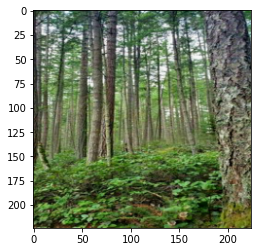

In [ ]:
xform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ColorJitter(brightness=0.1,contrast=0.3,saturation=0.2),
                            transforms.GaussianBlur(kernel_size=5),
                            transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('291_test_dataset/full_dataset', transform=xform)
plt.imshow(dataset_full[22][0].permute(1,2,0))
print(len(dataset_full))

In our full implementation, we want to use all of the available images for training. While testing, however, it is useful to have some photos available to verify that the model is making the correct predictions.

In [ ]:
n_all = len(dataset_full)
n_train = int(0.6 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(3621)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)
print(len(dataset_test), len(dataset_train))

20 28


In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

Making the model
---
Since our dataset is so small, there is little point in having a complex model. So, our goal is to have a model that is "good enough" while being as fast as possible. We tested a few candidates for use as a pretrained model, and found that of DenseNet, ResNet, MobileNet, and VGG-16, ResNet-18 seems to be the best candidate. Running on a cpu, ResNet was about 5 times faster than the other 4 options, while providing comparable accuracy.

The main challenge now is to figure out how to reduce overfitting. Since the dataset size is determined by the number of swipes the user has done, it starts at 0 images and grows linearly. As such, it is very easy for the model to overtrain and memorize the few dozen photos it has. To reduce the chance of overfitting, we will use plenty of data augmentation, as well as dropout.

In [168]:
# Create a model using ResNet
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(p=0.2),
                         nn.Linear(model.fc.in_features, 2))
torch.nn.init.xavier_uniform_(model.fc[1].weight)

Parameter containing:
tensor([[ 0.0664,  0.0976,  0.0753,  ..., -0.0358, -0.0840,  0.0667],
        [ 0.0368, -0.0693,  0.0653,  ...,  0.1052,  0.0185,  0.0894]],
       requires_grad=True)

In [169]:
device = torch.device('cpu')
model = model.to(device)

In [170]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [171]:
def run_train(model, opt, sched):
  nsamples_train = len(dataset_train)
  loss_sofar, correct_sofar = 0, 0
  model.train()
  with torch.enable_grad():
    for samples, labels in loader_train:
      samples = samples.to(device)
      labels = labels.to(device)
      opt.zero_grad()
      outs = model(samples)
      _, preds = torch.max(outs.detach(), 1)
      loss = criterion(outs, labels)
      loss.backward()
      opt.step()
      loss_sofar += loss.item() * samples.size(0)
      correct_sofar += torch.sum(preds == labels.detach())
  sched.step()
  return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_test(model):
  n_test = len(dataset_test)
  loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for samples, labels in loader_test:
      samples = samples.to(device)
      labels = labels.to(device)
      outs = model(samples)
      loss += criterion(outs, labels)
      _, preds = torch.max(outs.detach(), 1)
      correct_mask = preds == labels
      correct += correct_mask.sum(0).item()
  return loss / n_test, correct / n_test

def run_all(model, optimizer, scheduler, n_epochs):
  for epoch in range(n_epochs):
    loss_train, acc_train = run_train(model, optimizer, scheduler)
    loss_test, acc_test = run_test(model)
    print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [173]:
# droupout = 0.2
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 0.1639 acc 0.9286, test loss 0.2796 acc 0.6000
epoch 1: train loss 0.0546 acc 0.9643, test loss 0.3015 acc 0.6000
epoch 2: train loss 0.1838 acc 0.9286, test loss 0.2257 acc 0.6500
epoch 3: train loss 0.1185 acc 0.8929, test loss 0.3387 acc 0.5500
epoch 4: train loss 0.0294 acc 1.0000, test loss 0.3351 acc 0.5000
epoch 5: train loss 0.3517 acc 0.8571, test loss 0.2421 acc 0.6000
epoch 6: train loss 0.4308 acc 0.8571, test loss 0.3226 acc 0.5500
epoch 7: train loss 0.1276 acc 0.9286, test loss 0.3295 acc 0.5500
epoch 8: train loss 0.0171 acc 1.0000, test loss 0.3394 acc 0.5000
epoch 9: train loss 0.3037 acc 0.8929, test loss 0.2527 acc 0.7000


Up next are functions for working with single, unrated images. First, `classify_images` takes the name of an image in the unrated folder and predicts if it is a like or a dislike. This will be used to make predictions on which items to recommend to the user.

`print_unrated_image` is a convenience function for displaying an unrated image alongside its predicted rating.

In [124]:
# Given a single image in the unrated folder, predict how the user will rate it
def classify_image(model, img_name):
    # Find the image in the folder and prepare it for the model
    img_path = '291_test_dataset/unrated/' + img_name + '.jpg'
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except:
        # If image cannot be found, return 0 for dislike
        print("Image not found")
        return 0
    img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = img_transform(pil_img) # Transform image

    model.eval()
    with torch.no_grad():
        img = img.to(device).unsqueeze(0) # Add a dimention so the model can use it
        out = model(img)
        _, pred = torch.max(out.detach(), 1)
    return pred.item()

# Convenience function for displaying an unrated image with its predicted rating
def print_unrated_image(img_name):
    img_path = '291_test_dataset/unrated/' + img_name + '.jpg'
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except:
        # If image cannot be found, return 0 for dislike
        print("Image not found")
        return 0
    img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = img_transform(pil_img) # Transform image
    plt.imshow(img.permute(1,2,0))
    print("Predicted class:", dataset_full.classes[classify_image(model, img_name)])

Predicted class: dislikes


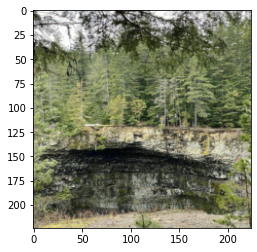

In [125]:
print_unrated_image("brandywine-trail-1")

In [183]:
# Simple convenience function for printing a number of samples from each dataset
def print_dataset_samples(num_samples=10, dataset="train"):
    for i in range(num_samples):
        if dataset == "train":
            img = dataset_train[i]
        elif dataset == "test":
            img = dataset_test[i]
        else:
            img = dataset_full[i]
        plt.imshow(img[0].permute(1,2,0))
        print(dataset_full.classes[img[1]])
        plt.show()

dislikes


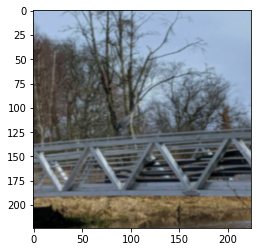

dislikes


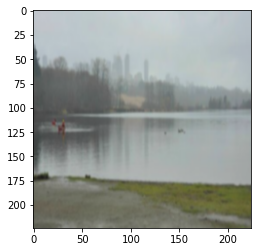

In [185]:
print_dataset_samples(2, "full")